In [1]:
%load_ext autoreload
%autoreload 2

# Weak Supervision VAE

Implementing some version of [Weak Supervision Variational Auto-Encoder](https://openreview.net/forum?id=0oDzoRjrbj) by Tonolini et al. 

There are some differences with the paper especially around the decoders and its still a work-in-progress as its mainly tested around the census data at the moment.

In [2]:
import os
import sys

os.chdir("../..")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import torch

import flippers
from examples.notebook_utils import load_wrench_dataset, MetricsMaker
from examples.Experiments._vae import WeakLabelVAE

M = {}

c:\Users\liamt\Repos\flippers\flippers\_core\_core.py:151: UserWarning: Polarity mapping if not furnished.
Make sure L captures all possible values of each weak labelers.
  warnings.warn(
Epoch [19/19]: 100%|██████████| 19/19 [00:14<00:00,  1.34it/s, Loss=4.7]


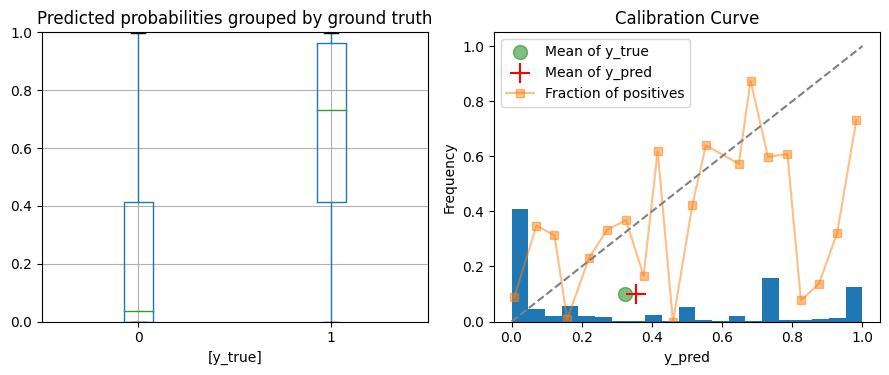

cdr {'F1': 0.652, 'Average_Precision': 0.618, 'AUC': 0.796, 'Accuracy': 0.748, 'Balanced_Accuracy': 0.743}


c:\Users\liamt\Repos\flippers\flippers\_core\_core.py:151: UserWarning: Polarity mapping if not furnished.
Make sure L captures all possible values of each weak labelers.
  warnings.warn(
Epoch [6/6]: 100%|██████████| 6/6 [00:15<00:00,  2.57s/it, Loss=7.0]


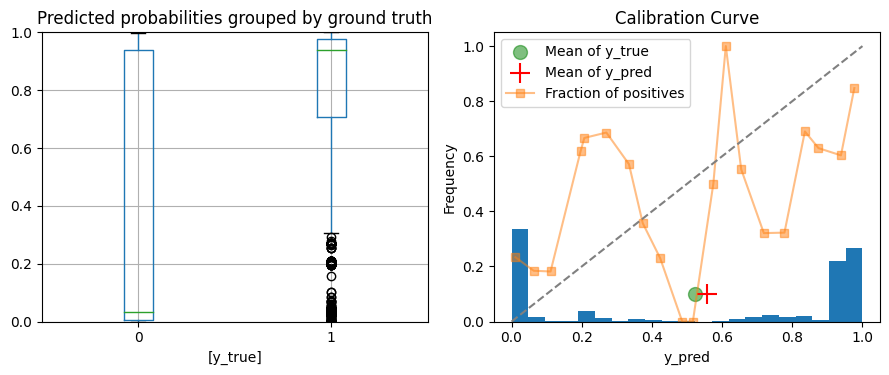

yelp {'F1': 0.727, 'Average_Precision': 0.782, 'AUC': 0.764, 'Accuracy': 0.7, 'Balanced_Accuracy': 0.697}


c:\Users\liamt\Repos\flippers\flippers\_core\_core.py:151: UserWarning: Polarity mapping if not furnished.
Make sure L captures all possible values of each weak labelers.
  warnings.warn(
Epoch [101/101]: 100%|██████████| 101/101 [00:14<00:00,  7.21it/s, Loss=10.8]


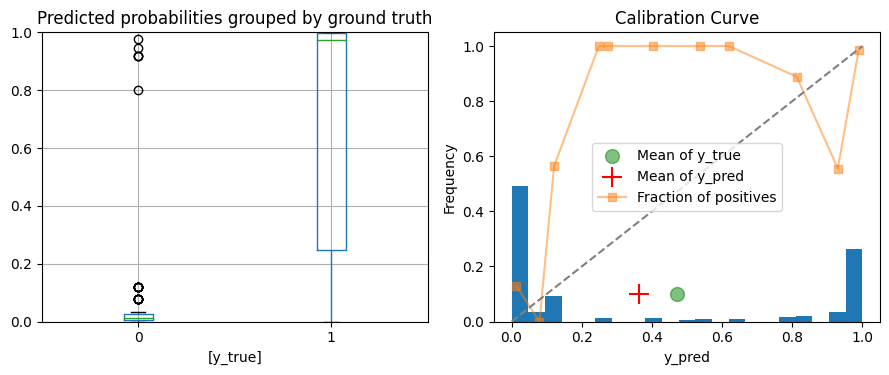

youtube {'F1': 0.802, 'Average_Precision': 0.909, 'AUC': 0.877, 'Accuracy': 0.836, 'Balanced_Accuracy': 0.829}


c:\Users\liamt\Repos\flippers\flippers\_core\_core.py:151: UserWarning: Polarity mapping if not furnished.
Make sure L captures all possible values of each weak labelers.
  warnings.warn(
Epoch [16/16]: 100%|██████████| 16/16 [00:16<00:00,  1.02s/it, Loss=4.8]


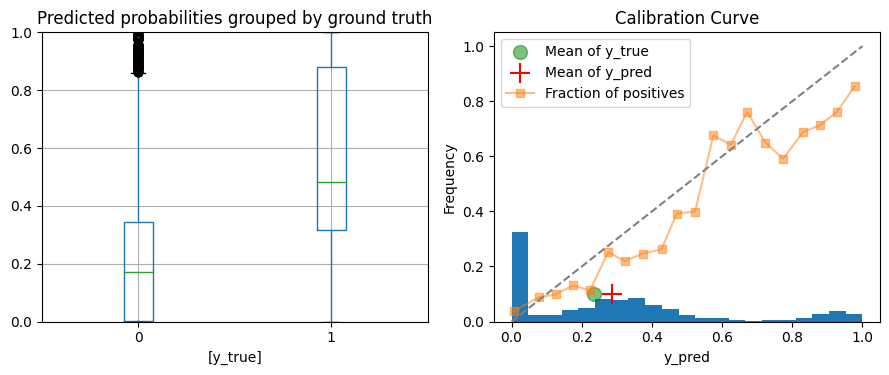

census {'F1': 0.573, 'Average_Precision': 0.631, 'AUC': 0.824, 'Accuracy': 0.828, 'Balanced_Accuracy': 0.711}


c:\Users\liamt\Repos\flippers\flippers\_core\_core.py:151: UserWarning: Polarity mapping if not furnished.
Make sure L captures all possible values of each weak labelers.
  warnings.warn(
Epoch [8/8]: 100%|██████████| 8/8 [00:14<00:00,  1.87s/it, Loss=4.6] 


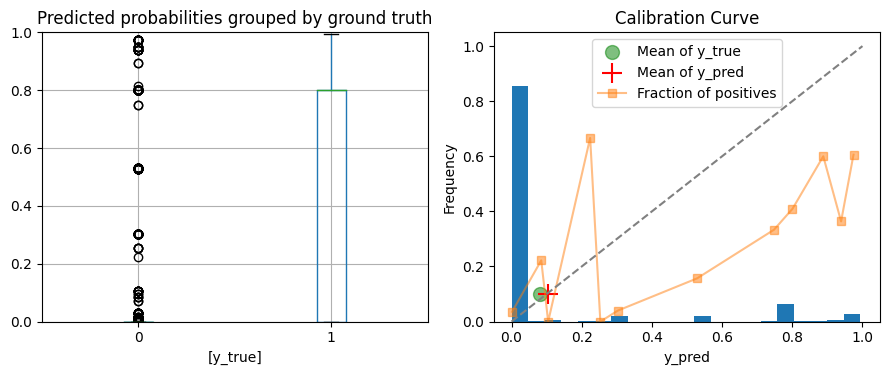

spouse {'F1': 0.485, 'Average_Precision': 0.381, 'AUC': 0.8, 'Accuracy': 0.898, 'Balanced_Accuracy': 0.76}


c:\Users\liamt\Repos\flippers\flippers\_core\_core.py:151: UserWarning: Polarity mapping if not furnished.
Make sure L captures all possible values of each weak labelers.
  warnings.warn(
Epoch [9/9]: 100%|██████████| 9/9 [00:13<00:00,  1.49s/it, Loss=5.4] 


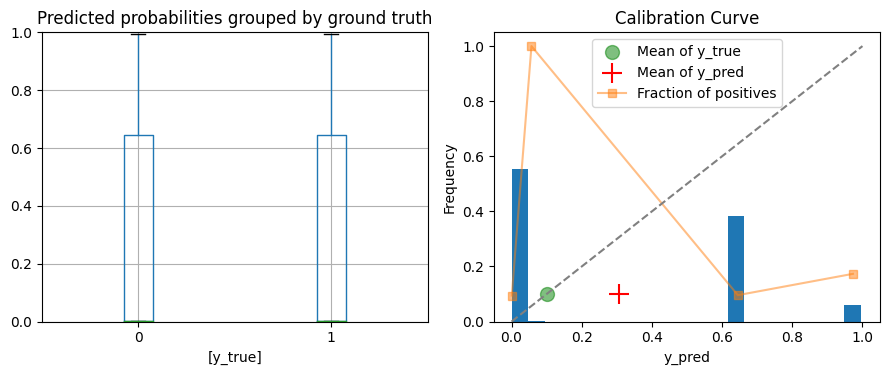

basketball {'F1': 0.174, 'Average_Precision': 0.117, 'AUC': 0.527, 'Accuracy': 0.549, 'Balanced_Accuracy': 0.515}


c:\Users\liamt\Repos\flippers\flippers\_core\_core.py:151: UserWarning: Polarity mapping if not furnished.
Make sure L captures all possible values of each weak labelers.
  warnings.warn(
Epoch [36/36]: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s, Loss=1.2]


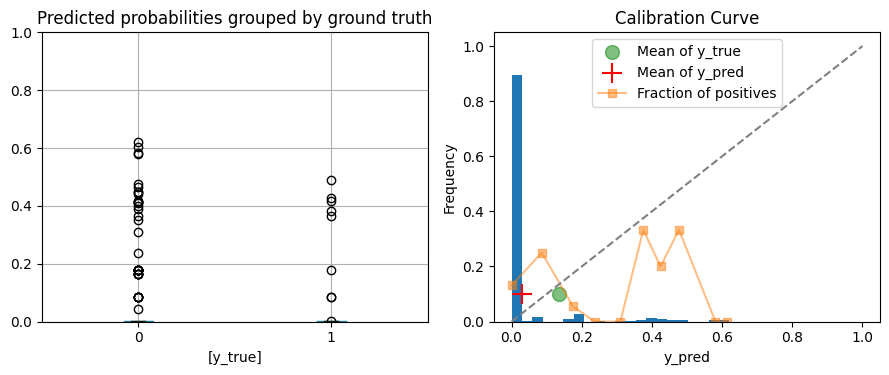

sms {'F1': 0.0, 'Average_Precision': 0.143, 'AUC': 0.501, 'Accuracy': 0.858, 'Balanced_Accuracy': 0.495}


c:\Users\liamt\Repos\flippers\flippers\_core\_core.py:151: UserWarning: Polarity mapping if not furnished.
Make sure L captures all possible values of each weak labelers.
  warnings.warn(
Epoch [23/23]: 100%|██████████| 23/23 [00:14<00:00,  1.64it/s, Loss=6.7]


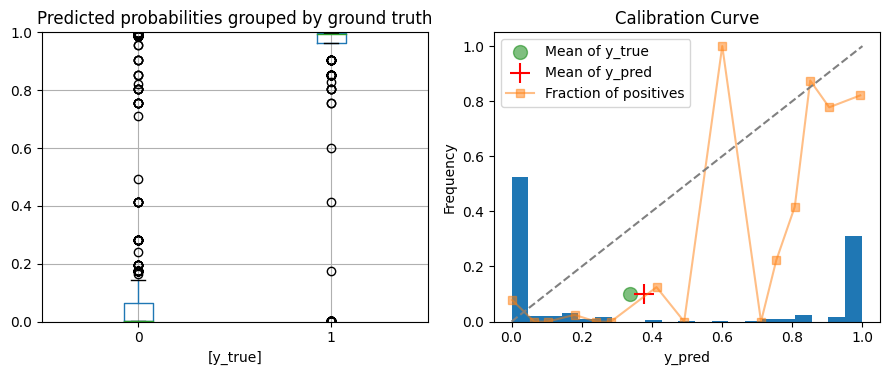

tennis {'F1': 0.832, 'Average_Precision': 0.791, 'AUC': 0.886, 'Accuracy': 0.882, 'Balanced_Accuracy': 0.879}


In [3]:
datasets = ["cdr", "yelp", "youtube", "census", "spouse", "basketball", "sms", "tennis"]
for dataset in datasets:
    data, weak_labels, polarities = load_wrench_dataset(dataset)
    train, dev, test = data
    L_train, L_dev, L_test = weak_labels
    class_balances = list(
        dev["label"].astype(int).value_counts(normalize=True).sort_index()
    )
    y_test = test["label"].astype(int).values
    Metrics = MetricsMaker(y_test, L_test)

    m = WeakLabelVAE(polarities=polarities, class_balances=class_balances)
    m.fit(L_train)
    M[dataset] = Metrics.score(m)
    print(dataset, M[dataset])

In [4]:
from examples.notebook_utils import dataset_to_metric

df = pd.DataFrame(M)


# Formatting function to underline entries
def underline_entries(x):
    is_metric = x.index == dataset_to_metric[x.name]
    return ["text-decoration: underline" if v else "" for v in is_metric]


# Underlines the metrics used in the wrench benchmark
df.style.apply(underline_entries).format("{:.3f}")

,cdr,yelp,youtube,census,spouse,basketball,sms,tennis
F1,0.652,0.727,0.802,0.573,0.485,0.174,0.000,0.832
Average_Precision,0.618,0.782,0.909,0.631,0.381,0.117,0.143,0.791
AUC,0.796,0.764,0.877,0.824,0.800,0.527,0.501,0.886
Accuracy,0.748,0.700,0.836,0.828,0.898,0.549,0.858,0.882
Balanced_Accuracy,0.743,0.697,0.829,0.711,0.760,0.515,0.495,0.879
